# Problem Statement - Hate Speech Detection

Sentiment analysis is widely applied to voice of the customer materials such as reviews and survey responses, online and social media, and healthcare materials for applications that range from marketing to customer service to clinical medicine.

The objective of this task is to detect hate speech in tweets. For simplicity, we say a tweet contains hate speech if it has a racist or sexist sentiment associated with it. So, the task is to classify racist or sexist tweets from other tweets.

Formally, given a training sample of tweets and labels, where label '1' denotes the tweet is racist/sexist and label '0' denotes the tweet is not racist/sexist, your objective is to predict the labels on the test dataset.

## Evaluation
Precision = TP/TP+FP
Recall = TP/TP+FN

F1 Score = 2*(Recall * Precision) / (Recall + Precision)


In [1]:
# ------------------------------------------------------------------------------------------------------------------
# Kennedy kairu Kariuki #Sentimently
# ------------------------------------------------------------------------------------------------------------------

# Twitter Sentiment Analysis - Hate Speech Detection

# ‘1’ = tweet is racist/sexist 
# ‘0’ = tweet is NOT racist/sexist

# Eveluation Metric: F1 Score = 2(Recall Precision) / (Recall + Precision)

In [2]:
# Load Libraries
# ------------------------------------------------------------------------------------------------------------------


import re                           # Regular expressions for cleaning text

import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt 
%matplotlib inline

import seaborn as sns

import string
import nltk

import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
# Variables/modules
# ------------------------------------------------------------------------------------------------------------------

from nltk.stem.porter import *
stemmer = PorterStemmer()

from wordcloud import WordCloud

#Bag Of Words Model
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=6000, stop_words='english')

#TF-IDF freq
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=6000, stop_words='english')

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# SVM
from sklearn.svm import SVC
svm = SVC()

# Cross Validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


In [4]:
# Function to clean tweet data string
# ------------------------------------------------------------------------------------------------------------------

def fnc_clean_tweet(tweet_txt, pattern):
    r = re.findall(pattern, tweet_txt)
    for i in r:
        tweet_txt = re.sub(i, '', tweet_txt) #Substitute pattern with blank
        
    return tweet_txt    

# Function to collect hashtags
# ------------------------------------------------------------------------------------------------------------------
def fnc_extract_hashtag(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [5]:
# Load data and maintain a RAW copy
# ------------------------------------------------------------------------------------------------------------------

train_RAW  = pd.read_csv('data/Hate_Speech_Train_Tweets.csv')
test_RAW = pd.read_csv('data/Hate_Speech_Test_Tweets.csv')

train  = train_RAW
test = test_RAW

train.shape

(31962, 3)

In [6]:
# Combine Training and Test dataframes
# ------------------------------------------------------------------------------------------------------------------

allTweets = train.append(test, ignore_index=True, sort=False)
allTweets.head()

,id,label,tweet
0,1,0.0,@user when a father is dysfunctional and is s...
1,2,0.0,@user @user thanks for #lyft credit i can't us...
2,3,0.0,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...
4,5,0.0,factsguide: society now #motivation


In [7]:
# Clean tweeter Text
# Add new column tidy_tweet with the clean tweet text
# ------------------------------------------------------------------------------------------------------------------

allTweets['tidy_tweet'] = np.vectorize(fnc_clean_tweet)(allTweets['tweet'], "@[\w]*") #Remove twitter handles (@user) 

allTweets['tidy_tweet'] = allTweets['tidy_tweet'].str.replace("[^a-zA-Z#]", " ") # Remove special xters, nums, punctuations

allTweets['tidy_tweet'] = allTweets['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3])) # Remove short words

allTweets.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,when father dysfunctional selfish drags kids i...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks #lyft credit cause they offer wheelchai...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model love take with time
4,5,0.0,factsguide: society now #motivation,factsguide society #motivation


In [8]:
# Tokenization
# ------------------------------------------------------------------------------------------------------------------

tokenized_tweet = allTweets['tidy_tweet'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [when, father, dysfunctional, selfish, drags, ...
1    [thanks, #lyft, credit, cause, they, offer, wh...
2                              [bihday, your, majesty]
3                     [#model, love, take, with, time]
4                   [factsguide, society, #motivation]
Name: tidy_tweet, dtype: object

In [9]:
# Stemming the words *********************************** e.g something stemmed to someth, beautiful to beauti, happily to happi???
# ------------------------------------------------------------------------------------------------------------------

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
#tokenized_tweet.head()

# Combine tokens back together
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

allTweets['tidy_tweet'] = tokenized_tweet

allTweets.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,when father dysfunct selfish drag kid into dys...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thank #lyft credit caus they offer wheelchair ...
2,3,0.0,bihday your majesty,bihday your majesti
3,4,0.0,#model i love u take with u all the time in ...,#model love take with time
4,5,0.0,factsguide: society now #motivation,factsguid societi #motiv


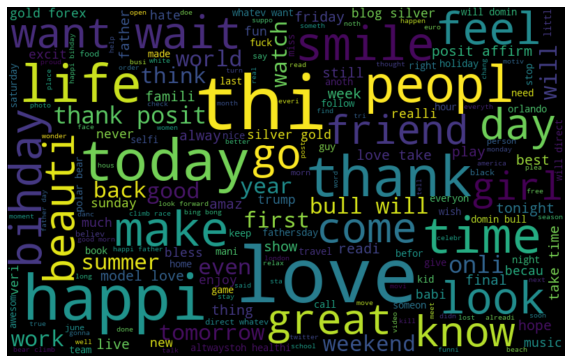

In [10]:
# Show word cloud
# ------------------------------------------------------------------------------------------------------------------

allWords = ' '.join([text for text in allTweets['tidy_tweet']])

tweetsWordCloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(allWords)

plt.figure(figsize=(10, 7))
plt.imshow(tweetsWordCloud, interpolation="bilinear")
plt.axis('off')

plt.show()

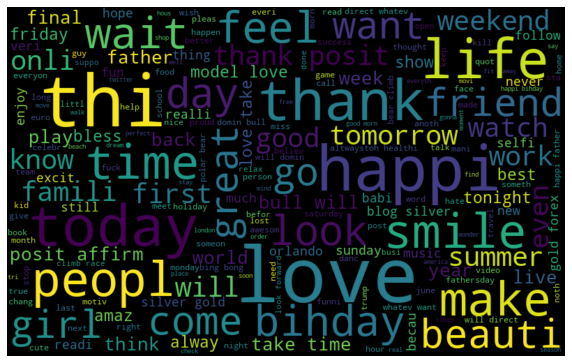

In [11]:
# Words in Non Racist/Sexist tweets
# ------------------------------------------------------------------------------------------------------------------

normalWords =' '.join([text for text in allTweets['tidy_tweet'][allTweets['label'] == 0]])

normalWordCloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normalWords)

plt.figure(figsize=(10, 7))
plt.imshow(normalWordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

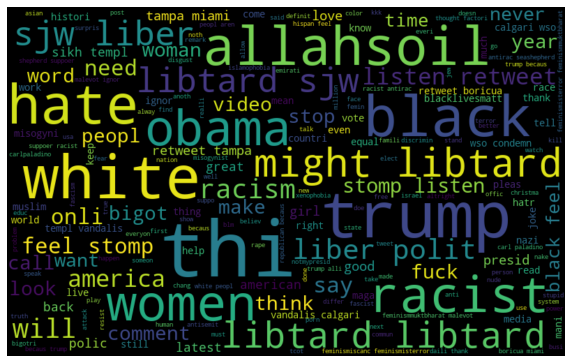

In [12]:
# Words in Racist/Sexist tweets
# ------------------------------------------------------------------------------------------------------------------

racistWords =' '.join([text for text in allTweets['tidy_tweet'][allTweets['label'] == 1]])

racistWordCloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(racistWords)

plt.figure(figsize=(10, 7))
plt.imshow(racistWordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [13]:
# Extracting hashtags tweets
# ------------------------------------------------------------------------------------------------------------------

normalTags = fnc_extract_hashtag(allTweets['tidy_tweet'][allTweets['label'] == 0])    #Extract Non-racist/sexist hashtags

racistTags = fnc_extract_hashtag(allTweets['tidy_tweet'][allTweets['label'] == 1])    #Extract racist/sexist hashtags

# unnesting lists
normalTags = sum(normalTags,[])
racistTags = sum(racistTags,[])

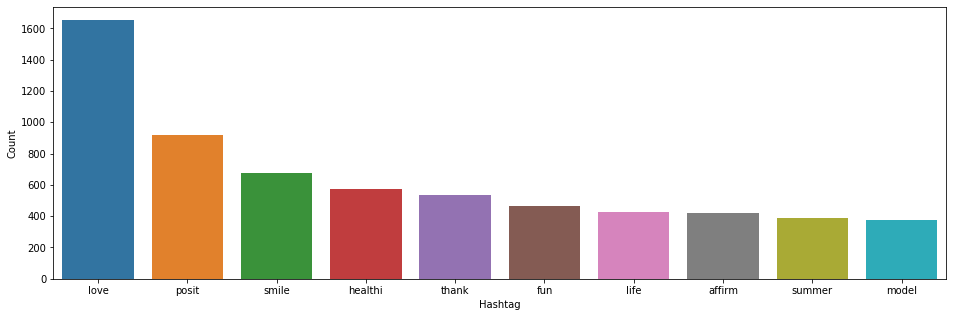

In [14]:
# Plot top [10] non-racist/sexist hashtags
# ------------------------------------------------------------------------------------------------------------------

a = nltk.FreqDist(normalTags)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 

plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

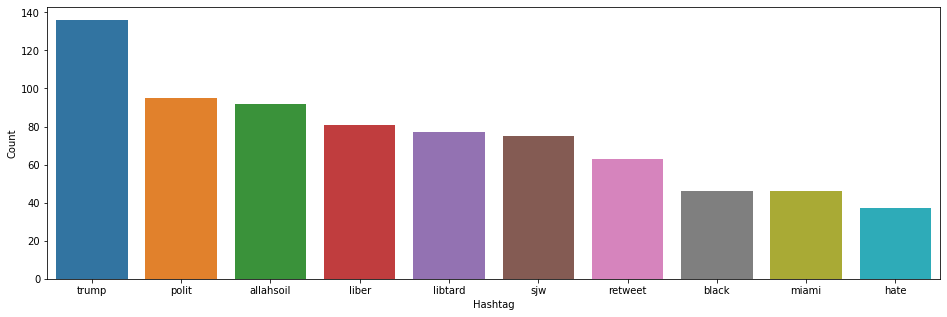

In [15]:
# Plot top [10] racist/sexist hashtags
#

b = nltk.FreqDist(racistTags)
e = pd.DataFrame({'Hashtag': list(b.keys()), 
                  'Count': list(b.values())})

# selecting top 10 most frequent hashtags
e = e.nlargest(columns="Count", n = 10)  

plt.figure(figsize=(16,5))
ax = sns.barplot(data=e, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

In [16]:
# Feature extraction - Bag-of-Words [sklearn’s CountVectorizer]
# ------------------------------------------------------------------------------------------------------------------

# bag-of-words feature matrix
bow = bow_vectorizer.fit_transform(allTweets['tidy_tweet'])

In [17]:
# TF-IDF Features - Looks at frequency of occurence for terms

# TF = (Number of times term t appears in a document)/(Number of terms in the document)
# IDF = log(N/n), where, N is the number of documents and n is the number of documents a term t has appeared in.
# TF-IDF = TF*IDF

# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(allTweets['tidy_tweet'])

In [18]:
# Model using Bag Of Words - Logistic regression
# ------------------------------------------------------------------------------------------------------------------

train_bow = bow[:31962,:]
test_bow = bow[31962:,:]

# splitting data into training and validation set
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, train['label'], random_state=42, test_size=0.1)

#lreg = LogisticRegression()
#lreg.fit(xtrain_bow, ytrain)                     # training the model

#prediction = lreg.predict_proba(xvalid_bow)      # predicting on the validation set
#prediction_int = prediction[:,1] >= 0.3          # if prediction is greater than or equal to 0.3 than 1 else 0
#prediction_int = prediction_int.astype(np.int)

#f1_score(yvalid, prediction_int) # calculating f1 score

In [19]:
# Predict test data using the bow model

#test_pred = lreg.predict_proba(test_bow)
#test_pred_int = test_pred[:,1] >= 0.3
#test_pred_int = test_pred_int.astype(np.int)
#test['label'] = test_pred_int
#submission = test[['id','label']]
#submission.to_csv('data/sub_lreg_bow.csv', index=False)    # writing data to a CSV file

In [23]:
# Model Using TD_IDF - Logistic regression
# ------------------------------------------------------------------------------------------------------------------

train_tfidf = tfidf[:31962,:]
test_tfidf = tfidf[31962:,:]

xtrain_tfidf = train_tfidf[ytrain.index]
xvalid_tfidf = train_tfidf[yvalid.index]

#lreg.fit(xtrain_tfidf, ytrain)                   # Train model

#prediction = lreg.predict_proba(xvalid_tfidf)    # Predict validation set
#prediction_int = prediction[:,1] >= 0.3
#prediction_int = prediction_int.astype(np.int)

#f1_score(yvalid, prediction_int)

In [24]:
# Predict Test data using TD-IDF - Logistic regression

#test_pred = lreg.predict_proba(test_tfidf)
#test_pred_int = test_pred[:,1] >= 0.3
#test_pred_int = test_pred_int.astype(np.int)
#test['label'] = test_pred_int
#submission = test[['id','label']]
#submission.to_csv('data/sub_lreg_td-idf.csv', index=False) # writing data to a CSV file

In [25]:
# Model using SVM
# ------------------------------------------------------------------------------------------------------------------

svm.fit(xtrain_bow, ytrain)        # Build using bow

svm.fit(xtrain_tfidf, ytrain)      # Build using TD-IDF

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [26]:
# Applying k-Fold Cross Validation

acc = cross_val_score(estimator = svm, X = xtrain_bow, y = ytrain, cv = 10)
acc.mean()
acc.std()

9.2727148214765692e-05

In [27]:
svm = SVC(kernel = 'rbf', random_state = 0, gamma = 0.14, C =11)

svm.fit(xtrain_bow, ytrain)

prediction = svm.predict(xvalid_bow)
prediction_int = prediction.astype(np.int)

f1_score(yvalid, prediction_int)


0.67039106145251404

In [28]:
#prediction on test set
test_pred = svm.predict(test_bow)

test_pred_int = test_pred.astype(np.int)
test['label'] = test_pred_int

submission = test[['id','label']]
submission.to_csv('data/svmrbfbow.csv', index=False)   # writing data to a CSV file

print("End SVM")

End SVM
